# Innovation Lab
 

In [1]:
import os
import torch
import flwr as fl
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch import nn
from torch import optim
from typing import Dict
from collections import OrderedDict
from sklearn.preprocessing import LabelEncoder
from flwr.common import NDArrays, Scalar
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE} using PyTorch {torch.__version__}")


Training on cpu using PyTorch 2.5.1+cpu


## Parameters

This section defines all the possible hyperparameters that can be used to configure the model. Just update the values to your desired configuration.

In [ ]:
# Dataset hyperparameters
MAX_LEN = 256

# Model hyperparameters
EMBED_SIZE = 128
HIDDEN_SIZE = 256
NUM_LAYERS = 2
DROPOUT = 0.5

# Training hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.01
NUM_EPOCHS = 10
NUM_CLIENTS = 10

# General hyperparameters
RANDOM_STATE = 42
VERBOSE = True
np.random.seed(RANDOM_STATE)

## Load data
Next, we define the datastructure, load the dataset and perform the necessary pre-processing. We begin by defining the dataset.

In [3]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
import nltk
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
import ssl
import os

# Bypass SSL certificate verification
ssl._create_default_https_context = ssl._create_unverified_context

try:
    # Load stopwords
    stopwords = nltk.corpus.stopwords.words("english")
    print("Stopwords loaded successfully.")

    # Load punkt tokenizer
    punkt = nltk.data.load('tokenizers/punkt/english.pickle')
    print("Punkt tokenizer loaded successfully.")
except LookupError as e:
    print(f"Error: {e}")
    print("Ensure 'stopwords' and 'punkt' are correctly placed in the specified directory.")

# Dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, maxlen):
        self.texts = [text[:maxlen] for text in texts]
        self.labels = labels
        self.maxlen = maxlen

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = torch.tensor(self.texts[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return text, label

def _collate_fn(batch, vocab):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=vocab["<pad>"])
    labels = torch.tensor(labels, dtype=torch.long)
    return texts_padded, labels

def _remove_stopwords(text):
    stop = set(nltk.corpus.stopwords.words("english"))
    return (
        pd.Series(text)
        .fillna("")  # Replace NaN with empty string
        .astype(str)
        .str.lower()
        .replace(r"[^\w\s]", "", regex=True)
        .apply(nltk.word_tokenize)
        .apply(
            lambda sentence: " ".join([word for word in sentence if word not in stop])
        )
    )

class Vocabulary:
    def __init__(self, tokens):
        self.word_to_idx = {}
        self.idx_to_word = []
        self.add_tokens(tokens)

    def add_tokens(self, tokens):
        for token in tokens:
            if token not in self.word_to_idx:
                self.idx_to_word.append(token)
                self.word_to_idx[token] = len(self.idx_to_word) - 1

    def update(self, new_tokens):
        self.add_tokens(new_tokens)

    def __getitem__(self, token):
        return self.word_to_idx.get(token, self.word_to_idx["<unk>"])  # Handle unknown tokens

    def __len__(self):
        return len(self.idx_to_word)

    def add_special_tokens(self, tokens):
        self.update(tokens)

def load_dataset(file_path, maxlen):
    # Load data from CSV
    df = pd.read_csv(file_path)

    # Ensure columns are as expected
    assert 'statement' in df.columns and 'status' in df.columns, "CSV must have 'statement' and 'status' columns."

    # Preprocess text data
    text = _remove_stopwords(df['statement'])
    tokens = [nltk.word_tokenize(sentence) for sentence in text]

    # Flatten the list of tokens for vocabulary creation
    flat_tokens = [token for sentence in tokens for token in sentence]
    vocab = Vocabulary(flat_tokens)

    # Add special tokens
    vocab.add_special_tokens(["<pad>", "<unk>"])

    # Encode labels
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(df['status'])

    # Encode texts
    encoded_texts = [[vocab[token] for token in sentence] for sentence in tokens]

    # Apply maxlen to encoded texts
    encoded_texts = [text[:maxlen] for text in encoded_texts]

    encoded_df = pd.DataFrame(
        {
            "text": encoded_texts,
            "category": labels,
        }
    )

    return encoded_df, vocab, label_encoder


def create_dataloader(text, labels, vocab, maxlen, shuffle=True):
    dataset = CustomDataset(text.tolist(), labels.tolist(), maxlen)
    return DataLoader(
        dataset,
        batch_size=32,
        shuffle=shuffle,
        collate_fn=lambda x: _collate_fn(x, vocab),
    )

# Load data from 'sample.csv'
MAX_LEN = 256  # Example maximum length, adjust as needed
RANDOM_STATE = 42  # Set a seed for reproducibility

from sklearn.model_selection import train_test_split

try:
    df, vocab, label_encoder = load_dataset('Data.csv', MAX_LEN)
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        df["text"], df["category"], test_size=0.2, random_state=RANDOM_STATE
    )

    train_loader = create_dataloader(train_texts, train_labels, vocab, MAX_LEN)
    test_loader = create_dataloader(test_texts, test_labels, vocab, MAX_LEN, shuffle=False)
    print("Data loaders created successfully.")
except Exception as e:
    print(f"Error: {e}")


Stopwords loaded successfully.
Punkt tokenizer loaded successfully.
Data loaders created successfully.


Afterward, we define all the necessary methods to load and pre-process the data. Therefore, we performed tokenization, stopword removal, building up a vocabulary, and encoded the tokens into a numerical representation on our own. For this we used NLTK and scikit-learn respectively. Furthermore, we incorporated a max length into our feature to reduce further computational resources. Additionally, we added padding to the text-feature to unify it, as the input for the model. For this, we used pytorch. Lastly, we label encode the target feature with scikit-learn.

Next, we need to call the `load_dataset` method with the desired max length.

Lastly, we split the dataset into training and testing sets, based on a 80:20 ratio and transform them into PyTorch DataLoader objects.

## State-of-the-art baseline
This section implements and evaluates a state-of-the-art bidirectional LSTM model for text classification.

### Implementation
First, we define the model itself with its necessary parameters. Afterward, we implement a method 
- to train the model based on provided dataset.
- evaluate the model based on a provided dataset by computing the utility metrics accuracy, precision, recall and f1.

In [7]:
df.sample(5)


,text,category
22261,"[789, 1662, 14468, 4097, 535, 387, 5695, 33, 1...",6
41400,"[167, 3896, 178, 84, 138, 229, 216, 68895, 4005]",2
20065,"[31447, 29387, 45698, 45699, 5044, 3521, 45700...",6
30036,"[13219, 42, 167, 810, 3061, 42650, 1368, 1080,...",5
780,"[925, 193, 1215, 736]",3


In [8]:
class BidirectionalLSTM(nn.Module):
    """
    A bidirectional LSTM model for sequence classification.

    Args:
        vocab_size (int): Size of the vocabulary.
        output_size (int): Number of output classes.
        padding_idx (int): Padding index for the embedding layer.
        embed_size (int, optional): Size of the embedding vectors (default: 128).
        hidden_size (int, optional): Number of hidden units in the LSTM (default: 256).
        num_layers (int, optional): Number of LSTM layers (default: 2).
        dropout (float, optional): Dropout rate applied to LSTM outputs (default: 0.5).
    """

    def __init__(self, vocab_size, output_size, padding_idx, embed_size=128, hidden_size=256, num_layers=2, dropout=0.5):
        super(BidirectionalLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=padding_idx)
        self.rnn = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.rnn(embedded)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        out = self.dropout(hidden)
        out = self.fc(out)
        return out


In [9]:
def train_model(model, train_loader, num_epochs, optimizer, device=DEVICE, verbose=False):
    """
    Trains the model for a specified number of epochs.
    """
    criterion = nn.CrossEntropyLoss()
    model.train()

    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0
        correct = 0
        total = 0

        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        if verbose:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")


In [10]:
def evaluate_model(model, test_loader, device=DEVICE, verbose=False):
    """
    Evaluates the model on the test dataset. The function calculates and returns loss, accuracy, precision, recall
    and F1 score for the model's predictions on the test data.
    """
    criterion = nn.CrossEntropyLoss()
    model.eval()

    total, correct = 0, 0
    total_loss = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    total_loss /= len(test_loader)
    accuracy = correct / total

    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    if verbose:
        print(f"Test Loss: {total_loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    return total_loss, accuracy, precision, recall, f1

### Training
In this section, we train the model, based on `NUM_EPOCHS` specified. We however, evaluate the model after each epoch and save the results to a prior specified file.

In [11]:
def run_centralised(model, train_loader, test_loader, epochs, lr, momentum=0.9, device=DEVICE, verbose=False):
    """ 
    Trains and evaluates the model using centralized training.
    """
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    train_model(model, train_loader, epochs, optim, device)
    loss, accuracy, precision, recall, f1 = evaluate_model(model, test_loader, device)

    if verbose:
        print(f"Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    return accuracy, loss, precision, recall, f1


Defining the file to save the results to:

In [12]:
file_path = "results/results_baseline.csv"
os.makedirs("results", exist_ok=True)

Initializing the bidirectional LSTM, based on the provided hyperparameters:

In [13]:
model = BidirectionalLSTM(
    vocab_size=len(vocab),
    output_size= len(label_encoder.classes_),
    padding_idx=vocab["<pad>"],
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(DEVICE)

Lastly, we need to start the training:

In [14]:
%%time
epochs_count = 0
for epochs in range(NUM_EPOCHS):
    epochs_count += 1
    acc, loss, precision, recall, f1 = run_centralised(model, train_loader, test_loader, epochs=1, lr=LEARNING_RATE, verbose=False)
    with open(file_path, "a") as file:
        file.write(f"{epochs_count},{acc},{loss},{precision},{recall},{f1}\n")

100%|██████████| 1/1 [6:35:27<00:00, 23727.25s/it]


CPU times: total: 1d 6h 58min 44s
Wall time: 21h 51min 53s


## Towards Federated LSTM
This section implements and evaluates the model we want to federate. Futher we implement the server and client for the federation process and start a simulation to evaluate its performance.

### Implementation
First, we define the model itself with its necessary parameters.

In [15]:
class LSTM(nn.Module):
    """
    A single-layer LSTM model for text classification.

    Args:
        vocab_size (int): Size of the vocabulary.
        output_size (int): Number of output classes.
        padding_idx (int): Padding index for the embedding layer.
        embed_size (int, optional): Size of the embedding vectors (default: 128).
        hidden_size (int, optional): Number of hidden units in the LSTM (default: 256).
        num_layers (int, optional): Number of LSTM layers (default: 2).
        dropout (float, optional): Dropout rate applied to LSTM outputs (default: 0.5).
    """
    def __init__(
        self,
        vocab_size,
        output_size,
        padding_idx,
        embed_size=128,
        hidden_size=256,
        num_layers=2,
        dropout=0.5,
    ):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=padding_idx)
        self.rnn = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False,
            dropout=dropout,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.rnn(embedded)
        hidden = hidden[-1]
        out = self.dropout(hidden)
        out = self.fc(out)
        return out


### Training
To have a value to compare to, we train and evaluate the model based on `NUM_EPOCHS` specified. The reason for this is to see how well the model overall performs and furthermore have a upper bound for our federated model performance.

First, define the file to save the results to:

In [16]:
file_path = "results/results_no_fed.csv"
os.makedirs("results", exist_ok=True)

Initializing the uni-directional LSTM, based on the provided hyperparameters:

In [17]:
model = LSTM(
    vocab_size=len(vocab),
    output_size= len(label_encoder.classes_),
    padding_idx=vocab["<pad>"],
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(DEVICE)

Initializing the bidirectional LSTM, based on the provided hyperparameters:

In [18]:
%%time
epochs_count = 0
for epochs in range(1):
    epochs_count += epochs
    acc, loss, precision, recall, f1 = run_centralised(model, train_loader, test_loader, epochs=1, lr=LEARNING_RATE, verbose=False)
    with open(file_path, "a") as file:
       file.write(f"{epochs_count},{acc},{loss},{precision},{recall},{f1}\n")


100%|██████████| 1/1 [1:57:31<00:00, 7051.87s/it]


CPU times: total: 2h 33s
Wall time: 1h 58min 26s


### Federated LSTM
Now we deal with federating the model and data.

#### Partition data
We start by partitioning the data into `num_partitions`. This is crucial for further work.

In [28]:
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from collections import Counter

def partition_dataset_stratified(train_loader, test_loader, vocab, num_partitions, batch_size, val_ratio=0.1):
    """ 
    Partitions the training dataset into subsets with stratified sampling and creates DataLoaders.
    Ensures label distribution is equal across all partitions while excluding rare classes.
    """
    # Extract dataset from DataLoader
    train_dataset = train_loader.dataset
    test_dataset = test_loader.dataset

    # Extract labels
    all_labels = [train_dataset[i][1].item() for i in range(len(train_dataset))]

    # Compute class distribution
    class_counts = Counter(all_labels)
    print("Class Distribution Before Filtering:", class_counts)

    # Identify rare classes to exclude (e.g., classes with <= 1 sample)
    rare_classes = [cls for cls, count in class_counts.items() if count <= 1]
    print("Rare Classes to Exclude:", rare_classes)

    # Filter out rare classes
    filtered_indices = [i for i in range(len(train_dataset)) if train_dataset[i][1].item() not in rare_classes]
    filtered_dataset = Subset(train_dataset, filtered_indices)

    # Update labels after filtering
    filtered_labels = [filtered_dataset[i][1].item() for i in range(len(filtered_dataset))]

    # Stratified K-Fold for splitting dataset into partitions
    skf = StratifiedKFold(n_splits=num_partitions, shuffle=True, random_state=2023)
    partitions = list(skf.split(range(len(filtered_dataset)), filtered_labels))

    trainloaders = []
    valloaders = []

    for train_idx, val_idx in partitions:
        # Further split the training indices into training and validation sets
        train_subset = Subset(filtered_dataset, train_idx)
        val_subset = Subset(filtered_dataset, val_idx)
        
        # Create DataLoaders for train and validation subsets
        trainloaders.append(DataLoader(train_subset, batch_size=batch_size, shuffle=True, 
                                       num_workers=0, collate_fn=lambda x: _collate_fn(x, vocab)))
        valloaders.append(DataLoader(val_subset, batch_size=batch_size, shuffle=False, 
                                     num_workers=0, collate_fn=lambda x: _collate_fn(x, vocab)))

    # Create DataLoader for the test set
    testloader = DataLoader(test_dataset, batch_size=128, collate_fn=lambda x: _collate_fn(x, vocab))

    return trainloaders, valloaders, testloader


In [29]:
trainloaders, valloaders, testloader = partition_dataset_stratified(train_loader, test_loader, vocab, NUM_CLIENTS, BATCH_SIZE)

Class Distribution Before Filtering: Counter({3: 13000, 2: 12366, 6: 8569, 0: 3108, 1: 2296, 5: 2140, 4: 954, 7: 1})
Rare Classes to Exclude: [7]


##### Visualization
We also added a small visualization of the distribution of classes within on partition.

In [31]:
for i, loader in enumerate(trainloaders):
    labels = []
    for _, batch_labels in loader:
        labels.extend(batch_labels.numpy())
    print(f"Client {i} Label Distribution: {np.unique(labels, return_counts=True)}")


Client 0 Label Distribution: (array([0, 1, 2, 3, 4, 5, 6], dtype=int64), array([ 2900,  2143, 11541, 12133,   891,  1998,  7998], dtype=int64))
Client 1 Label Distribution: (array([0, 1, 2, 3, 4, 5, 6], dtype=int64), array([ 2900,  2143, 11541, 12133,   891,  1998,  7998], dtype=int64))
Client 2 Label Distribution: (array([0, 1, 2, 3, 4, 5, 6], dtype=int64), array([ 2900,  2143, 11541, 12133,   891,  1998,  7998], dtype=int64))
Client 3 Label Distribution: (array([0, 1, 2, 3, 4, 5, 6], dtype=int64), array([ 2901,  2142, 11541, 12134,   891,  1997,  7998], dtype=int64))
Client 4 Label Distribution: (array([0, 1, 2, 3, 4, 5, 6], dtype=int64), array([ 2901,  2143, 11542, 12134,   890,  1997,  7997], dtype=int64))
Client 5 Label Distribution: (array([0, 1, 2, 3, 4, 5, 6], dtype=int64), array([ 2901,  2143, 11542, 12134,   890,  1997,  7997], dtype=int64))
Client 6 Label Distribution: (array([0, 1, 2, 3, 4, 5, 6], dtype=int64), array([ 2901,  2143, 11542, 12134,   890,  1997,  7997], dtype=

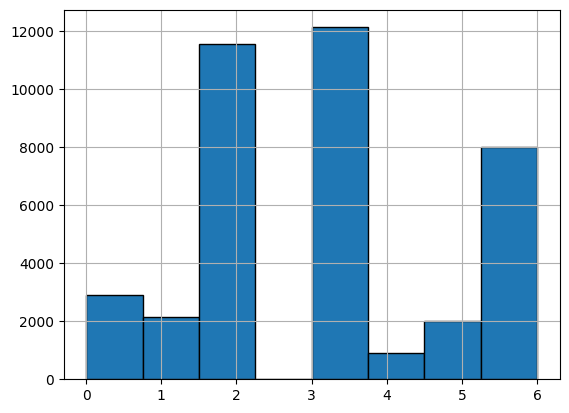

In [32]:
train_partition = trainloaders[1].dataset
partition_indices = train_partition.indices

plt.hist([train_partition.dataset[idx][1].item() for idx in partition_indices], bins=len(label_encoder.classes_), edgecolor="black")
plt.grid()


In [33]:
# Combine all labels into a single tensor
all_labels = torch.tensor([label for _, label in train_partition.dataset])

# Get unique labels
unique_labels = torch.unique(all_labels)
num_unique_labels = unique_labels.size(0)

print(f"Unique Labels: {unique_labels.tolist()}")
print(f"Number of Unique Labels: {num_unique_labels}")


Unique Labels: [0, 1, 2, 3, 4, 5, 6]
Number of Unique Labels: 7


#### Client
Next, we implement the client based on the Flower library

In [34]:
class Client(fl.client.NumPyClient):
    """
    A Federated Learning client for training and evaluating an LSTM model on the dataset.
    """
    def __init__(self, vocab_size, output_size, padding_idx, embed_size, hidden_size, num_layers, dropout, device, learning_rate, trainloader, valloader) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = valloader
        self.device = device
        self.learning_rate = learning_rate
        self.model = LSTM(
            vocab_size=vocab_size,
            output_size= output_size,
            padding_idx=padding_idx,
            embed_size=embed_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout
        ).to(device)


    def set_parameters(self, parameters):
        """ 
        Sets the model parameters from the provided list.
        """
        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        self.model.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config):
        """
        Returns the model parameters as a list of numpy arrays.
        """
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        """
        Trains the model on the local training data with the given parameters.
        """
        self.set_parameters(parameters)
        optim = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate, momentum=0.9)
        train_model(model=self.model, train_loader=self.trainloader, num_epochs=1, optimizer=optim, device=self.device, verbose=False,)
        return self.get_parameters({}), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        """
        Evaluates the model on the local validation data with the given parameters.
        """
        self.set_parameters(parameters)
        loss, accuracy, precision, recall, f1 = evaluate_model(self.model, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

And add some additional function to create and evaluate the client.

In [36]:
def get_evaluate_fn(vocab_size, output_size, padding_idx, embed_size, hidden_size, num_layers, dropout, device, testloader):
    """
    Creates an evaluation function for federated learning.
    """
    def evaluate_fn(server_round, parameters, config):
        model = LSTM(
            vocab_size=vocab_size,
            output_size= output_size,
            padding_idx=padding_idx,
            embed_size=embed_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout
        ).to(device)

        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

        loss, accuracy, precision, recall, f1 = evaluate_model(
            model, testloader
        )
        return loss, {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

    return evaluate_fn

In [37]:
def generate_client_fn(vocab_size, output_size, padding_idx, embed_size, hidden_size, num_layers, dropout, device, learning_rate, trainloaders, valloaders):
    """
    Creates a client function for federated learning.
    """
    def client_fn(cid: str):
        return Client(vocab_size, output_size, padding_idx, embed_size, hidden_size, num_layers, dropout, device, learning_rate, trainloader=trainloaders[int(cid)], valloader=valloaders[int(cid)]).to_client()

    return client_fn

#### Server
Lastly, we configure the aggregating strategy for the server and define the number of clients via the `NUM_CLIENTS` parameter. We further use all models to train and evaluate on all models available.

In [38]:
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.5, 
    fraction_evaluate=1,  
    min_available_clients=NUM_CLIENTS, 
    evaluate_fn=get_evaluate_fn(len(vocab), len(label_encoder.classes_), vocab["<pad>"], EMBED_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT, DEVICE, testloader)
)

In [39]:
client_fn_callback = generate_client_fn(len(vocab), len(label_encoder.classes_), vocab["<pad>"], EMBED_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT, DEVICE, LEARNING_RATE, trainloaders, valloaders)

#### Training
Next, we start the simulation of our federated ml model 

In [ ]:
# Run the simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn_callback,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_EPOCHS),
    strategy=strategy,
)

INFO :      Starting Flower simulation, config: num_rounds=3, no round_timeout
2024-11-21 23:36:05,297	INFO worker.py:1819 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'accelerator_type:G': 1.0, 'node:__internal_head__': 1.0, 'CPU': 8.0, 'object_store_memory': 249574195.0, 'node:127.0.0.1': 1.0, 'memory': 499148391.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(ClientAppActor pid=23220) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid

##### Results
Lastly, we save the results to a csv file

In [ ]:
import os
import pandas as pd

# Create the directory if it doesn't exist
output_dir = "results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Saving the CSV file
rows = []
for i in range(len(history.metrics_centralized['accuracy'])):
    loss = history.losses_centralized[i][1]
    epoch = history.metrics_centralized['accuracy'][i][0]
    accuracy = history.metrics_centralized['accuracy'][i][1]
    precision = history.metrics_centralized['precision'][i][1]
    recall = history.metrics_centralized['recall'][i][1]
    f1 = history.metrics_centralized['f1'][i][1]
    
    rows.append({
        'epoch_nr': epoch,
        'accuracy': accuracy,
        "loss": loss,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

df_metrics = pd.DataFrame(rows)

# Save the DataFrame to a CSV file in the results directory
csv_file_path = os.path.join(output_dir, f"results_federated_{NUM_CLIENTS}_clients.csv")
df_metrics.to_csv(csv_file_path, index=False)

print(f"Metrics saved to {csv_file_path}")


Metrics saved to results\results_federated_15_clients.csv


In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence
import nltk

# Define the function to save the server model
def save_model(model, path="server_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Function to preprocess a custom input
def preprocess_input(text, vocab, maxlen):
    # Remove stopwords and tokenize
    stop = set(nltk.corpus.stopwords.words("english"))
    text = (
        pd.Series([text])
        .str.lower()
        .replace(r"[^\w\s]", "", regex=True)
        .apply(nltk.word_tokenize)
        .apply(lambda sentence: [word for word in sentence if word not in stop])
    ).iloc[0]

    # Convert tokens to indices
    text_indices = [vocab[token] for token in text]
    
    # Pad the input to match the maximum length
    text_padded = pad_sequence(
        [torch.tensor(text_indices, dtype=torch.long)],
        batch_first=True,
        padding_value=vocab["<pad>"],
    )
    
    return text_padded

# Define a function to classify custom input
def classify_input(model, text, vocab, label_encoder, maxlen, device):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Preprocess the input
        preprocessed_text = preprocess_input(text, vocab, maxlen).to(device)
        
        # Pass the input through the model
        logits = model(preprocessed_text)
        prediction = torch.argmax(logits, dim=1).item()
        
        # Decode the label
        predicted_label = label_encoder.inverse_transform([prediction])[0]
        
        return predicted_label

# After federated training completes
# Save the server model
save_model(model)

# Load the saved model (optional, to ensure it's working correctly)
model_path = "server_model.pth"
model = LSTM(
    vocab_size=len(vocab),
    output_size=len(label_encoder.classes_),
    padding_idx=vocab["<pad>"],
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
).to(DEVICE)
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
print("Model loaded successfully.")

# Take custom input from the user
custom_text = input("Enter a text for classification: ")

# Classify the custom input
predicted_class = classify_input(model, custom_text, vocab, label_encoder, MAX_LEN, DEVICE)
print(f"The predicted class is: {predicted_class}")


Model saved to server_model.pth


C:\Users\hp\AppData\Local\Temp\ipykernel_19684\3074798946.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVI

Model loaded successfully.
The predicted class is: Normal
